In [0]:
%matplotlib inline

## **ConvNets for predicting bimatrix gameplay**

In [0]:
import pandas as pd
import numpy as np

import torch
import torch.optim as optim

import matplotlib.pyplot as plt

In [0]:
from tqdm import tqdm

In [0]:
df_train_features = pd.read_csv('./hb_train_feature.csv')
df_test_features = pd.read_csv('./hb_test_feature.csv')
df_train_truth = pd.read_csv('./hb_train_truth.csv')

### **Configuration variables**

In [0]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
BATCH_SIZE = 32
SHUFFLE = True
SEED = 42
TRAIN_SPLIT = 0.6
VAL_SPLIT = 0.2
TEST_SPLIT = 0.2
EPOCHS = 10

### **Convert data format and normalize**

In [0]:
def view_game_matrix(df_row):
    """
    View payoffs in 3x3 matrix format
    inputs
        df_row : Pandas series object, e.g. df.iloc[0]
    returns
        [row_payoffs, col_payoffs] : np.array (2x3x3)
    """
    return df_row.values.reshape(2, 3, 3)

def normalize(matrix):
    """
    Method to normalize a given matrix
    input:
        matrix : np.array, the payouts 
    output:
        np.array, the matrix normalized
    """
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    return (matrix - min_val) / (max_val - min_val)
    
def get_payoff_matrices(df, rows_first=False, normalized=True):
    """
    Convert input dataframe into new normed payoff data
    input:
        df : pandas.DataFrame
        rows_first : bool, if true, separate data into first row payoffs and then columns, 
        otherwise row and col payoffs lumped next to each other
        normalized : bool, if true, normalize the matrices
    output:
        np.array, the converted data 
    """
    if normalized:
        df = df.apply(normalize, axis=0)
    matrices = np.zeros([2 * df.shape[0], 3, 3])
    for row_ix in range(df.shape[0]):
        payoffs = view_game_matrix(df.iloc[row_ix])
        if rows_first:
            matrices[row_ix] = payoffs[0]
            matrices[row_ix + df.shape[0]] = payoffs[1]
        else:
            matrices[row_ix * 2] = payoffs[0]
            matrices[row_ix * 2 + 1] = payoffs[1]
#     if normalized:
#         matrices = np.array([normalize(matrices[ix]) for ix in range(matrices.shape[0])])
    return matrices

In [0]:
norm_payoffs = get_payoff_matrices(df_train_features, rows_first=True, normalized=True)

In [8]:
norm_payoffs[:3]

array([[[0.8 , 0.5 , 0.8 ],
        [0.2 , 0.9 , 0.6 ],
        [0.3 , 0.1 , 0.1 ]],

       [[0.2 , 0.51, 0.5 ],
        [0.1 , 0.7 , 0.3 ],
        [0.6 , 0.05, 0.45]],

       [[0.7 , 1.  , 0.48],
        [0.1 , 0.29, 0.4 ],
        [0.4 , 0.6 , 1.  ]]])

### **Augment data with row swaps**

In [0]:
import itertools
orderings = list(itertools.permutations([0, 1, 2]))

In [0]:
norm_payoffs_r = norm_payoffs[:250]
norm_payoffs_c = norm_payoffs[250:]

In [0]:
def transform(payoffs, rotations):  # rotations = [2, 1, 0]
#     temp = norm_payoffs_c[:, 0]
    new_payoffs = np.zeros(payoffs.shape)
    for ix in range(len(rotations)):
        new_payoffs[:, ix] = payoffs[:, rotations[ix]]
    return new_payoffs

In [0]:
augmented_data = []
augmented_labels = []
for order in orderings:
    trans_payoffs_r = transform(norm_payoffs_r, order)
    trans_payoffs_c = transform(norm_payoffs_c, order)
    trans_freq = df_train_truth.apply(lambda x: x[list(order)], axis=1).values
    augmented_data.append(np.array([trans_payoffs_r, trans_payoffs_c]))
    augmented_labels.append(trans_freq)

In [0]:
augmented_data[0][:3]

## **Prepare actual data**

In [0]:
from torch.utils.data import Dataset

In [0]:
game_labels = np.array(augmented_labels).reshape(250 * 6, 3)

In [0]:
game_data = np.array(augmented_data).transpose([0, 2, 1, 3, 4]).reshape(250 * 6, 2, 3, 3)

In [17]:
df_train_features.head()

,r11,r12,r13,r21,r22,r23,r31,r32,r33,c11,c12,c13,c21,c22,c23,c31,c32,c33
0,80.0,50.0,80.0,20.0,90.0,60.0,30.0,10.0,10.0,70.0,30.0,40.0,60.0,10.0,70.0,10.0,40.0,50.0
1,20.0,51.0,50.0,10.0,70.0,30.0,60.0,5.0,45.0,20.0,10.0,60.0,51.0,70.0,5.0,50.0,30.0,45.0
2,70.0,100.0,48.0,10.0,29.0,40.0,40.0,60.0,100.0,70.0,10.0,40.0,100.0,29.0,60.0,48.0,40.0,100.0
3,20.0,60.0,70.0,30.0,90.0,20.0,40.0,40.0,50.0,40.0,20.0,80.0,90.0,40.0,90.0,60.0,10.0,60.0
4,13.0,80.0,60.0,74.0,20.0,70.0,60.0,100.0,10.0,13.0,74.0,60.0,80.0,20.0,100.0,60.0,70.0,10.0


#### **Add / convert channels (feature engineering)**
Predicting from the perspective of the row player. The row player may only care about the value with respect to the highest value, as well as its difference to the other payoff.

In [18]:
# Difference between the row and col payoffs
game_data_rc_diffs = game_data[:, 0, :, :] - game_data[:, 1, :, :]
game_data_rc_diffs[:3]

array([[[ 0.1 ,  0.2 ,  0.4 ],
        [-0.4 ,  0.8 , -0.1 ],
        [ 0.2 , -0.3 , -0.4 ]],

       [[ 0.  ,  0.41, -0.1 ],
        [-0.41,  0.  ,  0.25],
        [ 0.1 , -0.25,  0.  ]],

       [[ 0.  ,  0.9 ,  0.08],
        [-0.9 ,  0.  , -0.2 ],
        [-0.08,  0.2 ,  0.  ]]])

In [19]:
# Difference between the payoff max and payoffs

## Get maxes
max_rows = np.max(game_data[:, 0, :, :], axis=(1, 2))
max_cols = np.max(game_data[:, 1, :, :], axis=(1, 2))

## Expand and convert to previous data shape
max_rows = np.repeat(max_rows, 9).reshape((1500, 3, 3))
max_cols = np.repeat(max_cols, 9).reshape((1500, 3, 3))

game_data_maxdiff_r = game_data[:, 0, :, :] - max_rows
game_data_maxdiff_c = game_data[:, 1, :, :] - max_cols

game_data_maxdiff_r[:3]

array([[[-0.1 , -0.4 , -0.1 ],
        [-0.7 ,  0.  , -0.3 ],
        [-0.6 , -0.8 , -0.8 ]],

       [[-0.5 , -0.19, -0.2 ],
        [-0.6 ,  0.  , -0.4 ],
        [-0.1 , -0.65, -0.25]],

       [[-0.3 ,  0.  , -0.52],
        [-0.9 , -0.71, -0.6 ],
        [-0.6 , -0.4 ,  0.  ]]])

In [20]:
game_data.shape

(1500, 2, 3, 3)

In [21]:
game_data_maxdiff_r.shape

(1500, 3, 3)

### **Setup datasets**
Consider the following multichannel datasets:

1. **Direct Payoffs**: direct normalized payoffs of row and column players, with each player's payoffs being a channel. (1500 x 2 x 3 x 3)  
2. **Payoff Differences**: only include the differences between the row and column, as well as the differences between the max values. Start off with row - col, row - max_row, col - max_col (1500 x 3 x 3 x 3)  
3. **Combined**: combo of the two above. (1500 x 5 x 3 x 3)
4. **Row**: only include payoffs related to the row, i.e. normed row payoffs, row - col, row - max (1500 x 3 x 3 x 3)

In [0]:
# Direct Payoffs is already in `game_data`

In [0]:
game_data_diffs = np.array([game_data_rc_diffs, game_data_maxdiff_r, game_data_maxdiff_c]).transpose(1, 0, 2, 3)

In [0]:
game_data_combined = np.concatenate([game_data, game_data_diffs], axis=1)

In [25]:
game_data_combined[0]

array([[[ 0.8,  0.5,  0.8],
        [ 0.2,  0.9,  0.6],
        [ 0.3,  0.1,  0.1]],

       [[ 0.7,  0.3,  0.4],
        [ 0.6,  0.1,  0.7],
        [ 0.1,  0.4,  0.5]],

       [[ 0.1,  0.2,  0.4],
        [-0.4,  0.8, -0.1],
        [ 0.2, -0.3, -0.4]],

       [[-0.1, -0.4, -0.1],
        [-0.7,  0. , -0.3],
        [-0.6, -0.8, -0.8]],

       [[ 0. , -0.4, -0.3],
        [-0.1, -0.6,  0. ],
        [-0.6, -0.3, -0.2]]])

In [0]:
game_data_row = np.concatenate([np.expand_dims(game_data[:, 0, :, :], 1), game_data_diffs[:,0:2, :, :]], axis=1)

In [27]:
game_data_row[0]

array([[[ 0.8,  0.5,  0.8],
        [ 0.2,  0.9,  0.6],
        [ 0.3,  0.1,  0.1]],

       [[ 0.1,  0.2,  0.4],
        [-0.4,  0.8, -0.1],
        [ 0.2, -0.3, -0.4]],

       [[-0.1, -0.4, -0.1],
        [-0.7,  0. , -0.3],
        [-0.6, -0.8, -0.8]]])

***Might need to renormalize the above but unclear***

In [0]:
class GameDataset(Dataset):
    """Bimatrix game dataset"""
    def __init__(self, data, labels):
        """
        Args:
            data: game payoffs; (num_samples, channels, row, col)
            labels: frequency of actions; (num_samples, freq)
        """
        self.samples = []
        self.data = data
        self.labels = labels
        self.load_samples()
        
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, ix):
        return self.samples[ix]

    def load_samples(self):
        for ix in range(self.data.shape[0]):
            self.samples.append((
                torch.tensor(self.data[ix], dtype=torch.float).to(DEVICE), 
                torch.tensor(self.labels[ix], dtype=torch.float).to(DEVICE)))

In [0]:
def load_game_data(data, labels, batch_size=BATCH_SIZE, shuffle=SHUFFLE):
    torch.manual_seed(SEED)
    dataset = GameDataset(data, labels)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size = batch_size, shuffle=shuffle)
    return dataloader

## **Define the CNN**

In [0]:
import torch.nn as nn  
import torch.nn.functional as F

In [0]:
class ConvNet(nn.Module):
    def __init__(self, log_softmax=False, softmax=True):
        super(ConvNet, self).__init__()
        self.log = log_softmax
        self.soft = softmax
        # Input: 2 channels, 8 output channels, 3x3 conv -> 6x3x3 output
        self.conv1 = nn.Conv2d(2, 8, 3, padding=1) 
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        # self.conv3 = nn.Conv2d(16, 32, 3, padding=1)  # start simple
        # self.fc1 = nn.Linear(32 * 3 * 3, 144)  # 72, 16 * 3 * 3
        self.fc1 = nn.Linear(16 * 3 * 3, 72)
        # self.fc2 = nn.Linear(144, 72)
        self.fc2 = nn.Linear(72, 24)
        self.fc3 = nn.Linear(24, 3)  # Predict all three frequencies, use Softmax?
        self.log_softmax = nn.LogSoftmax(dim=1)
        self.softmax = nn.Softmax(dim=1)

        # For some reason doing the softmax in here is bad

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # x = F.relu(self.conv3(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        x = self.fc3(x)
        if self.log:
            return self.log_softmax(x)
        elif self.soft:
            return self.softmax(x)
        return x

    def infer(self, x):
        """Always return unlogged inference"""
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # x = F.relu(self.conv3(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        x = self.fc3(x)
        if self.soft:
            return self.softmax(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

## **Train the model**

In [0]:
np.random.seed(SEED)

# Shuffle data first
game_ix = list(range(len(game_data)))
np.random.shuffle(game_ix)

game_data_ = game_data[game_ix]
game_labels_ = game_labels[game_ix]

# Prepare splits
train_split = int(len(game_data_) * TRAIN_SPLIT)
test_split = int(len(game_data_) * (TRAIN_SPLIT + VAL_SPLIT))

train_data = game_data_[:train_split]
val_data = game_data_[train_split:test_split]
test_data = game_data_[test_split:]

train_labels = game_labels_[:train_split]
val_labels = game_labels_[train_split:test_split]
test_labels = game_labels_[test_split:]

train_val_data = game_data_[:test_split]
train_val_labels = game_labels_[:test_split]

In [0]:
def batch_quadratic_loss(batch_output, batch_label):
    loss = 0
    for ix in range(len(batch_output)):
        loss += np.sum([(batch_output[ix][i] - batch_label[ix][i]) ** 2. for i in range(3)])
    return loss
        

def evaluate(model, dataloader, model_softmax=False):
    softmax = nn.Softmax(dim=1)
    batch_quad_loss = 0
    outputs = []
    labels = []
    model.eval()
    for batch_ix, (data, label) in enumerate(dataloader):
        if model.soft:
            output = model(data)
        elif model.log:
            output = torch.exp(model(data))  # convert back regular probabilities
        else:
            output = softmax(model(data))
        batch_quad_loss += batch_quadratic_loss(output, label).cpu().detach().numpy()
        outputs.append(output.squeeze().cpu().detach().numpy())
        labels.append(label.squeeze().cpu().detach().numpy())

    val_actions = np.argmax(np.array(labels), axis=1)
    pred_actions = np.argmax(np.array(outputs), axis=1)
    action_acc = np.sum(val_actions == pred_actions) / val_actions.shape[0]

    return batch_quad_loss, action_acc, outputs

In [0]:
def train(model, loss_fn, dataloader, dataloader_val=None, epochs=EPOCHS, 
          log_targets=False, model_softmax=True, log=5, log_softmax_outputs=False, val_data=val_data, val_labels=val_labels):

    # # Multiple criterion
    # mse_loss = nn.MSELoss()
    # ce_loss = nn.CrossEntropyLoss() 
    softmax_fn = nn.Softmax(dim=1)
    log_softmax_fn = nn.LogSoftmax(dim=1)

    dataloader_actual_val = load_game_data(val_data, val_labels, batch_size=1, shuffle=False)
    loss_total = []
    acc_total = []
    acc_total_val = []
    for epoch in range(epochs):  # tqdm is buggy sometimes
        epoch_loss = 0
        for batch_ix, (data, label) in enumerate(dataloader):
            # print(data.shape)
            output = model(data)
            # print(output)
            target = torch.tensor(np.argmax(np.array(label.cpu()), axis=1), dtype=torch.long).to(DEVICE)
            optimizer.zero_grad()
            # loss = 1.0 * mse_loss(softmax(output), label) + 0.0 * ce_loss(output, target)
            if log_targets:
                # output = log_softmax_fn(output)
                label = torch.log(label)
                # print(label)
            if log_softmax_outputs:
                output = log_softmax_fn(output)
                # print(output)
            elif not model_softmax:
                output = softmax_fn(output)
            loss = loss_fn(output, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        loss_total.append(epoch_loss)
        quad_loss, acc, _ = evaluate(model, dataloader_val, model_softmax=model_softmax)
        quad_loss_val, acc_val, _ = evaluate(model, dataloader_actual_val, model_softmax=model_softmax)
        if (epoch + 1) % log == 0:
            print('Epoch {0:<2} | Training Loss: {1:<2f} | Quad Loss: {2:<2f} | Acc: {3:<2f} | Val Quad Loss: {4:<2f} | Val Acc: {5:<2f}'.format(
                epoch, epoch_loss, quad_loss, acc, quad_loss_val, acc_val))
        acc_total.append(acc)
        acc_total_val.append(acc_val)
    return loss_total, [acc_total, acc_total_val]

### ***Training setup 1: MSE Loss***

In [0]:
# Actaually train
model = ConvNet(log_softmax=False, softmax=True)
model = model.to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0001)

dataloader = load_game_data(train_data, train_labels, batch_size=4, shuffle=True)
EPOCHS = 50

softmax = nn.Softmax(-1)

In [0]:
dataloader_val = load_game_data(train_data, train_labels, batch_size=1, shuffle=False)
losses_4, acc_4 = train(model, criterion, dataloader, dataloader_val, 50, 
                        model_log_softmax=False, model_softmax=True)

 10%|█         | 5/50 [00:09<01:21,  1.81s/it]

Epoch 4  | Training Loss: 13.356469 | Quad Loss: 149.532846 | Acc: 0.603333 | Val Quad Loss: 53.438001 | Val Acc: 0.600000


 20%|██        | 10/50 [00:18<01:11,  1.80s/it]

Epoch 9  | Training Loss: 4.855099 | Quad Loss: 52.932650 | Acc: 0.786667 | Val Quad Loss: 21.960021 | Val Acc: 0.713333


 30%|███       | 15/50 [00:27<01:03,  1.82s/it]

Epoch 14 | Training Loss: 3.966478 | Quad Loss: 46.312471 | Acc: 0.794444 | Val Quad Loss: 19.509335 | Val Acc: 0.716667


 40%|████      | 20/50 [00:35<00:53,  1.78s/it]

Epoch 19 | Training Loss: 3.829102 | Quad Loss: 45.731646 | Acc: 0.782222 | Val Quad Loss: 19.030382 | Val Acc: 0.726667


 50%|█████     | 25/50 [00:44<00:44,  1.79s/it]

Epoch 24 | Training Loss: 3.745042 | Quad Loss: 44.817633 | Acc: 0.787778 | Val Quad Loss: 18.958290 | Val Acc: 0.726667


 60%|██████    | 30/50 [00:53<00:36,  1.81s/it]

Epoch 29 | Training Loss: 3.712326 | Quad Loss: 43.055956 | Acc: 0.807778 | Val Quad Loss: 18.237675 | Val Acc: 0.736667


 70%|███████   | 35/50 [01:03<00:27,  1.81s/it]

Epoch 34 | Training Loss: 3.652864 | Quad Loss: 43.056670 | Acc: 0.802222 | Val Quad Loss: 18.260844 | Val Acc: 0.736667


 80%|████████  | 40/50 [01:11<00:17,  1.79s/it]

Epoch 39 | Training Loss: 3.643195 | Quad Loss: 42.438613 | Acc: 0.808889 | Val Quad Loss: 17.976701 | Val Acc: 0.733333


 90%|█████████ | 45/50 [01:20<00:08,  1.77s/it]

Epoch 44 | Training Loss: 3.700454 | Quad Loss: 43.006393 | Acc: 0.795556 | Val Quad Loss: 18.327135 | Val Acc: 0.726667


100%|██████████| 50/50 [01:29<00:00,  1.79s/it]

Epoch 49 | Training Loss: 3.611298 | Quad Loss: 44.729711 | Acc: 0.795556 | Val Quad Loss: 18.692783 | Val Acc: 0.730000


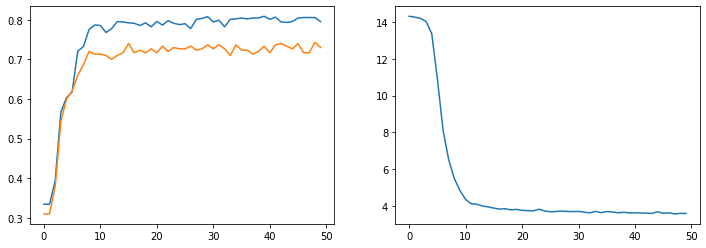

In [0]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_4[0])
plt.plot(acc_4[1])
plt.subplot(1, 2, 2)
plt.plot(losses_4)

In [0]:
# Actually train
model = ConvNet(log_softmax=False, softmax=True)
model = model.to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0001)

dataloader = load_game_data(train_data, train_labels, batch_size=4, shuffle=True)
EPOCHS = 50

softmax = nn.Softmax(-1)

dataloader_val = load_game_data(train_data, train_labels, batch_size=1, shuffle=False)
losses_4, acc_4 = train(model, criterion, dataloader, dataloader_val, epochs=50, 
                        log_targets=False, model_softmax=True, log=5)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_4[0])
plt.plot(acc_4[1])
plt.subplot(1, 2, 2)
plt.plot(losses_4)

In [0]:
# Actually train
model = ConvNet(log_softmax=False, softmax=True)
model = model.to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0001)

dataloader = load_game_data(train_data, train_labels, batch_size=4, shuffle=True)
EPOCHS = 50

softmax = nn.Softmax(-1)

dataloader_val = load_game_data(train_data, train_labels, batch_size=1, shuffle=False)
losses_4, acc_4 = train(model, criterion, dataloader, dataloader_val, epochs=50, 
                        log_targets=False, model_softmax=True, log=5)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_4[0])
plt.plot(acc_4[1])
plt.subplot(1, 2, 2)
plt.plot(losses_4)

### ***Training Setup 2: KLDivLoss***

In [0]:
# Actaually train
model_kl = ConvNet(log_softmax=False, softmax=False) # KL expects log probabilities as model output
model_kl = model_kl.to(DEVICE)

criterion = nn.KLDivLoss()
optimizer = optim.Adam(model_kl.parameters(), lr=1e-4, weight_decay=0.0001)

dataloader = load_game_data(train_data, train_labels, batch_size=1, shuffle=True)
EPOCHS = 50

In [0]:
# DOESN'T WORK YET

dataloader_val = load_game_data(train_data, train_labels, batch_size=1, shuffle=False)
losses_4_kl, acc_4_kl = train(model, criterion, dataloader, dataloader_val, 50, 
                              log_targets=False, model_softmax=False, 
                              log_softmax_outputs=True)  # But target probabilities should not be logged

### ***Training Setup 3: MSE with Payoff Differences***

In [0]:
np.random.seed(SEED)

# Shuffle data first
game_ix = list(range(len(game_data_diffs)))
np.random.shuffle(game_ix)

game_data_diffs_ = game_data_diffs[game_ix]
game_labels_ = game_labels[game_ix]

# Prepare splits
train_split = int(len(game_data_diffs_) * TRAIN_SPLIT)
test_split = int(len(game_data_diffs_) * (TRAIN_SPLIT + VAL_SPLIT))

train_data_diffs = game_data_diffs_[:train_split]
val_data_diffs = game_data_diffs_[train_split:test_split]
test_data_pd_diffs = game_data_diffs_[test_split:]

train_labels = game_labels_[:train_split]
val_labels = game_labels_[train_split:test_split]
test_labels = game_labels_[test_split:]

train_val_data_diffs = game_data_diffs_[:test_split]
train_val_labels = game_labels_[:test_split]

In [0]:
class ConvNetPd(nn.Module):
    """
    ConvNet Model for Payoff Differences data. Main difference is changing input to 3 channels
    - Keep it simple first
    """
    def __init__(self, log_softmax=False, softmax=True):
        super(ConvNetPd, self).__init__()
        self.log = log_softmax
        self.soft = softmax
        # Input: 3 channels, 8 output channels, 3x3 conv -> 8x3x3 output
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1) 
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        # self.conv3 = nn.Conv2d(16, 32, 3, padding=1)  # start simple
        # self.fc1 = nn.Linear(32 * 3 * 3, 144)  # 72, 16 * 3 * 3
        self.fc1 = nn.Linear(16 * 3 * 3, 72)
        # self.fc2 = nn.Linear(144, 72)
        self.fc2 = nn.Linear(72, 24)
        self.fc3 = nn.Linear(24, 3)  # Predict all three frequencies, use Softmax?
        self.log_softmax = nn.LogSoftmax(dim=1)
        self.softmax = nn.Softmax(dim=1)

        # For some reason doing the softmax in here is bad

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # x = F.relu(self.conv3(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        x = self.fc3(x)
        if self.log:
            return self.log_softmax(x)
        elif self.soft:
            return self.softmax(x)
        return x

    def infer(self, x):
        """Always return unlogged inference"""
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # x = F.relu(self.conv3(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        x = self.fc3(x)
        if self.soft:
            return self.softmax(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [0]:
class ConvNetPdBig(nn.Module):
    """
    ConvNet Model for all features data. Now input has 5 channels
    """
    def __init__(self, log_softmax=False, softmax=True, dropout=0., channels=3):
        super(ConvNetPdBig, self).__init__()
        self.log = log_softmax
        self.soft = softmax
        # Input: 3 channels, 8 output channels, 3x3 conv -> 8x3x3 output
        self.conv1 = nn.Conv2d(channels, 32, 3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  
        self.fc1 = nn.Linear(128 * 3 * 3, 512)  
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 3)  # Predict all three frequencies, use Softmax?
        self.log_softmax = nn.LogSoftmax(dim=1)
        self.softmax = nn.Softmax(dim=1)
        self.dropout_conv = nn.Dropout2d(p=0.1)
        self.dropout_fcn = nn.Dropout(p=dropout)
        self.gradients = None  # Placeholder for gradients

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout_conv(x)
        x = F.relu(self.conv2(x))
        x = self.dropout_conv(x)
        x = F.relu(self.conv3(x))
        # Hook to capture the gradients
        h = x.register_hook(self.activations_hook)
        x = self.dropout_conv(x)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.dropout_fcn(x)
        x = F.relu(self.fc2(x))
        x = self.dropout_fcn(x)
        x = F.relu(self.fc3(x))
        x = self.dropout_fcn(x)
        x = self.fc4(x)
        if self.log:
            return self.log_softmax(x)
        elif self.soft:
            return self.softmax(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # All dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    # Method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # Method for the activation extraction
    def get_activations(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout_conv(x)
        x = F.relu(self.conv2(x))
        x = self.dropout_conv(x)
        x = F.relu(self.conv3(x))
        return x

Epoch 4  | Training Loss: 4.467220 | Quad Loss: 45.335276 | Acc: 0.785556 | Val Quad Loss: 19.160284 | Val Acc: 0.740000
Epoch 9  | Training Loss: 3.526070 | Quad Loss: 42.026918 | Acc: 0.802222 | Val Quad Loss: 19.058079 | Val Acc: 0.716667
Epoch 14 | Training Loss: 3.393136 | Quad Loss: 38.169652 | Acc: 0.818889 | Val Quad Loss: 18.470097 | Val Acc: 0.726667
Epoch 19 | Training Loss: 3.032339 | Quad Loss: 37.760505 | Acc: 0.825556 | Val Quad Loss: 19.935129 | Val Acc: 0.733333
Epoch 24 | Training Loss: 2.780987 | Quad Loss: 30.157224 | Acc: 0.858889 | Val Quad Loss: 17.678267 | Val Acc: 0.726667
Epoch 29 | Training Loss: 2.585897 | Quad Loss: 28.187534 | Acc: 0.862222 | Val Quad Loss: 17.461957 | Val Acc: 0.740000
Epoch 34 | Training Loss: 2.389845 | Quad Loss: 25.165346 | Acc: 0.878889 | Val Quad Loss: 17.658575 | Val Acc: 0.730000
Epoch 39 | Training Loss: 2.148874 | Quad Loss: 22.419203 | Acc: 0.885556 | Val Quad Loss: 17.431904 | Val Acc: 0.740000
Epoch 44 | Training Loss: 2.0182

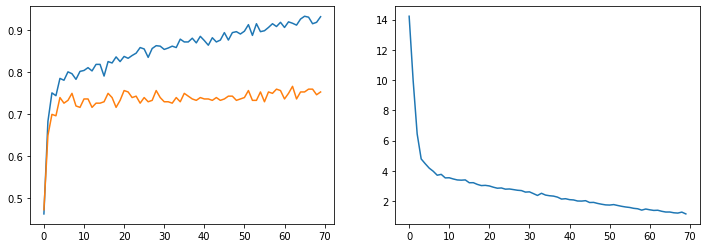

In [290]:
# Actually train
model_pd = ConvNetPdBig(log_softmax=False, softmax=True)
model_pd = model_pd.to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_pd.parameters(), lr=1e-4, weight_decay=0.00001)

dataloader = load_game_data(train_data_diffs, train_labels, batch_size=4, shuffle=True)
EPOCHS = 50

softmax = nn.Softmax(-1)

dataloader_val = load_game_data(train_data_diffs, train_labels, batch_size=1, shuffle=False)
losses_4, acc_4 = train(model_pd, criterion, dataloader, dataloader_val, epochs=70, 
                        log_targets=False, model_softmax=True, log=5, val_data=val_data_diffs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_4[0])
plt.plot(acc_4[1])
plt.subplot(1, 2, 2)
plt.plot(losses_4)

Epoch 4  | Training Loss: 4.240734 | Quad Loss: 44.362700 | Acc: 0.790000 | Val Quad Loss: 18.969782 | Val Acc: 0.736667
Epoch 9  | Training Loss: 3.606897 | Quad Loss: 43.042448 | Acc: 0.787778 | Val Quad Loss: 18.726707 | Val Acc: 0.726667
Epoch 14 | Training Loss: 3.556050 | Quad Loss: 38.797825 | Acc: 0.801111 | Val Quad Loss: 18.166499 | Val Acc: 0.736667
Epoch 19 | Training Loss: 3.240753 | Quad Loss: 39.537661 | Acc: 0.807778 | Val Quad Loss: 19.072731 | Val Acc: 0.726667
Epoch 24 | Training Loss: 3.139142 | Quad Loss: 33.548251 | Acc: 0.835556 | Val Quad Loss: 17.416658 | Val Acc: 0.736667
Epoch 29 | Training Loss: 2.933110 | Quad Loss: 32.692871 | Acc: 0.830000 | Val Quad Loss: 17.273147 | Val Acc: 0.706667
Epoch 34 | Training Loss: 2.801421 | Quad Loss: 30.201173 | Acc: 0.844444 | Val Quad Loss: 16.881941 | Val Acc: 0.740000
Epoch 39 | Training Loss: 2.625129 | Quad Loss: 28.490701 | Acc: 0.848889 | Val Quad Loss: 17.075607 | Val Acc: 0.736667
Epoch 44 | Training Loss: 2.5210

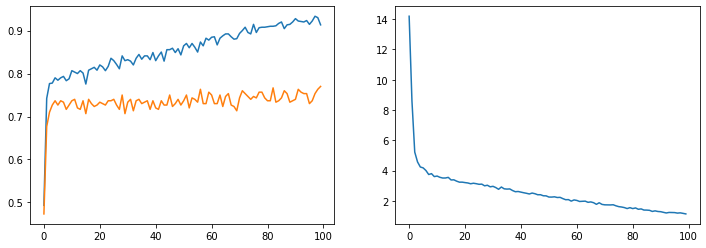

22.11337150766485 0.7433333333333333


In [301]:
# Actually train
model_pd = ConvNetPdBig(log_softmax=False, softmax=True)
model_pd = model_pd.to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_pd.parameters(), lr=1e-4, weight_decay=0.0001)

dataloader = load_game_data(train_data_diffs, train_labels, batch_size=4, shuffle=True)
EPOCHS = 50

softmax = nn.Softmax(-1)

dataloader_val = load_game_data(train_data_diffs, train_labels, batch_size=1, shuffle=False)
losses_4, acc_4 = train(model_pd, criterion, dataloader, dataloader_val, epochs=100, 
                        log_targets=False, model_softmax=True, log=5, val_data=val_data_diffs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_4[0])
plt.plot(acc_4[1])
plt.subplot(1, 2, 2)
plt.plot(losses_4)
plt.show()

dataloader_val = load_game_data(test_data_diffs, test_labels, batch_size=1, shuffle=False)
batch_ql, acc, predictions = evaluate(model_pd, dataloader_val)
print(batch_ql, acc)

In [300]:
dataloader_val = load_game_data(test_data_diffs, test_labels, batch_size=1, shuffle=False)
batch_ql, acc, predictions = evaluate(model_pd, dataloader_val)
print(batch_ql, acc)

18.57248523485032 0.7433333333333333


Epoch 4  | Training Loss: 5.501438 | Quad Loss: 64.365599 | Acc: 0.776667 | Val Quad Loss: 21.032659 | Val Acc: 0.680000
Epoch 9  | Training Loss: 5.031668 | Quad Loss: 57.969186 | Acc: 0.779167 | Val Quad Loss: 20.983629 | Val Acc: 0.696667
Epoch 14 | Training Loss: 4.832123 | Quad Loss: 61.075978 | Acc: 0.784167 | Val Quad Loss: 22.025818 | Val Acc: 0.686667
Epoch 19 | Training Loss: 4.556914 | Quad Loss: 52.706062 | Acc: 0.807500 | Val Quad Loss: 21.184644 | Val Acc: 0.706667
Epoch 24 | Training Loss: 4.320541 | Quad Loss: 48.226000 | Acc: 0.822500 | Val Quad Loss: 19.796599 | Val Acc: 0.713333
Epoch 29 | Training Loss: 4.057567 | Quad Loss: 44.504121 | Acc: 0.837500 | Val Quad Loss: 19.034386 | Val Acc: 0.720000
Epoch 34 | Training Loss: 3.923785 | Quad Loss: 43.667930 | Acc: 0.823333 | Val Quad Loss: 18.600355 | Val Acc: 0.740000
Epoch 39 | Training Loss: 3.584403 | Quad Loss: 43.658218 | Acc: 0.815000 | Val Quad Loss: 19.700282 | Val Acc: 0.713333
Epoch 44 | Training Loss: 3.3927

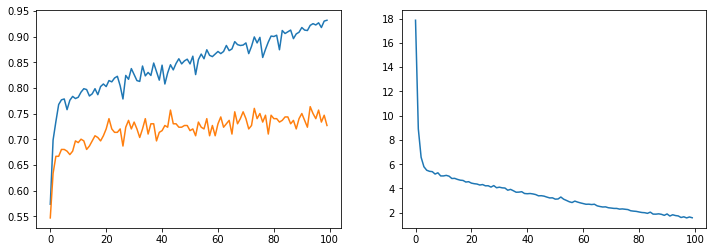

19.202570081666636 0.7266666666666667


In [316]:
# Actually train
model_pd = ConvNetPdBig(log_softmax=False, softmax=True)
model_pd = model_pd.to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_pd.parameters(), lr=1e-4, weight_decay=0.0001)

dataloader = load_game_data(train_val_data_diffs, train_val_labels, batch_size=4, shuffle=True)
EPOCHS = 50

softmax = nn.Softmax(-1)

dataloader_val = load_game_data(train_val_data_diffs, train_val_labels, batch_size=1, shuffle=False)
losses_4, acc_4 = train(model_pd, criterion, dataloader, dataloader_val, epochs=100, 
                        log_targets=False, model_softmax=True, log=5, val_data=test_data_diffs, val_labels=test_labels)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_4[0])
plt.plot(acc_4[1])
plt.subplot(1, 2, 2)
plt.plot(losses_4)
plt.show()

dataloader_val = load_game_data(test_data_diffs, test_labels, batch_size=1, shuffle=False)
batch_ql, acc, predictions = evaluate(model_pd, dataloader_val)
print(batch_ql, acc)

Epoch 4  | Training Loss: 5.786638 | Quad Loss: 71.410812 | Acc: 0.750833 | Val Quad Loss: 89.374466 | Val Acc: 0.380000
Epoch 9  | Training Loss: 5.032245 | Quad Loss: 57.656427 | Acc: 0.785000 | Val Quad Loss: 91.265797 | Val Acc: 0.353333
Epoch 14 | Training Loss: 4.804359 | Quad Loss: 56.550067 | Acc: 0.796667 | Val Quad Loss: 90.498452 | Val Acc: 0.363333
Epoch 19 | Training Loss: 4.500258 | Quad Loss: 54.891164 | Acc: 0.803333 | Val Quad Loss: 95.437627 | Val Acc: 0.340000
Epoch 24 | Training Loss: 4.273457 | Quad Loss: 47.407304 | Acc: 0.823333 | Val Quad Loss: 93.843675 | Val Acc: 0.363333
Epoch 29 | Training Loss: 3.991976 | Quad Loss: 44.552973 | Acc: 0.830833 | Val Quad Loss: 93.598049 | Val Acc: 0.346667
Epoch 34 | Training Loss: 3.938167 | Quad Loss: 43.240474 | Acc: 0.844167 | Val Quad Loss: 90.301788 | Val Acc: 0.330000
Epoch 39 | Training Loss: 3.630556 | Quad Loss: 43.109612 | Acc: 0.831667 | Val Quad Loss: 90.848655 | Val Acc: 0.346667
Epoch 44 | Training Loss: 3.4524

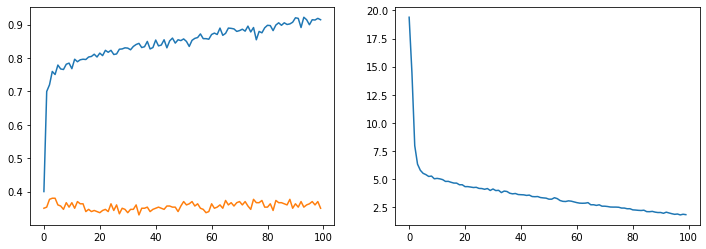

16.047110977524426 0.77


In [310]:
# Actually train
model_pd = ConvNetPdBig(log_softmax=False, softmax=True)
model_pd = model_pd.to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_pd.parameters(), lr=1e-4, weight_decay=0.0001)

dataloader = load_game_data(train_val_data_diffs, train_val_labels, batch_size=4, shuffle=True)
EPOCHS = 50

softmax = nn.Softmax(-1)

dataloader_val = load_game_data(train_val_data_diffs, train_val_labels, batch_size=1, shuffle=False)
losses_4, acc_4 = train(model_pd, criterion, dataloader, dataloader_val, epochs=100, 
                        log_targets=False, model_softmax=True, log=5, val_data=test_data_diffs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_4[0])
plt.plot(acc_4[1])
plt.subplot(1, 2, 2)
plt.plot(losses_4)
plt.show()

dataloader_val = load_game_data(test_data_diffs, test_labels, batch_size=1, shuffle=False)
batch_ql, acc, predictions = evaluate(model_pd, dataloader_val)
print(batch_ql, acc)

Epoch 4  | Training Loss: 13.918626 | Quad Loss: 164.352463 | Acc: 0.462222 | Val Quad Loss: 58.174185 | Val Acc: 0.460000
Epoch 9  | Training Loss: 8.246409 | Quad Loss: 89.186407 | Acc: 0.695556 | Val Quad Loss: 32.330154 | Val Acc: 0.663333
Epoch 14 | Training Loss: 4.556327 | Quad Loss: 53.043805 | Acc: 0.778889 | Val Quad Loss: 20.819994 | Val Acc: 0.676667
Epoch 19 | Training Loss: 3.978326 | Quad Loss: 46.618139 | Acc: 0.786667 | Val Quad Loss: 19.191300 | Val Acc: 0.736667
Epoch 24 | Training Loss: 3.764791 | Quad Loss: 45.842911 | Acc: 0.793333 | Val Quad Loss: 19.458286 | Val Acc: 0.740000
Epoch 29 | Training Loss: 3.700528 | Quad Loss: 43.002577 | Acc: 0.798889 | Val Quad Loss: 18.365958 | Val Acc: 0.756667
Epoch 34 | Training Loss: 3.656548 | Quad Loss: 43.277399 | Acc: 0.804444 | Val Quad Loss: 18.707201 | Val Acc: 0.733333
Epoch 39 | Training Loss: 3.598693 | Quad Loss: 42.139972 | Acc: 0.808889 | Val Quad Loss: 18.174332 | Val Acc: 0.740000
Epoch 44 | Training Loss: 3.65

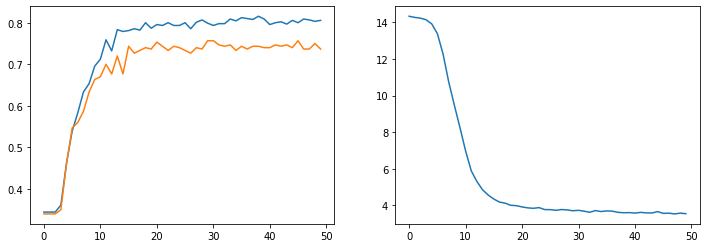

In [270]:
# Actually train
model_pd = ConvNetPd(log_softmax=False, softmax=True)
model_pd = model_pd.to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_pd.parameters(), lr=1e-4, weight_decay=0.0001)

dataloader = load_game_data(train_data_diffs, train_labels, batch_size=4, shuffle=True)
EPOCHS = 50

softmax = nn.Softmax(-1)

dataloader_val = load_game_data(train_data_diffs, train_labels, batch_size=1, shuffle=False)
losses_4, acc_4 = train(model_pd, criterion, dataloader, dataloader_val, epochs=50, 
                        log_targets=False, model_softmax=True, log=5, val_data=val_data_diffs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_4[0])
plt.plot(acc_4[1])
plt.subplot(1, 2, 2)
plt.plot(losses_4)

### ***Training Setup 4: MSE with All Features***

In [0]:
np.random.seed(SEED)

# Shuffle data first
game_ix = list(range(len(game_data_combined)))
np.random.shuffle(game_ix)

game_data_combined_ = game_data_combined[game_ix]
game_labels_ = game_labels[game_ix]

# Prepare splits
train_split = int(len(game_data_combined_) * TRAIN_SPLIT)
test_split = int(len(game_data_combined_) * (TRAIN_SPLIT + VAL_SPLIT))

train_data_combined = game_data_combined_[:train_split]
val_data_combined = game_data_combined_[train_split:test_split]
test_data_combined = game_data_combined_[test_split:]

train_labels = game_labels_[:train_split]
val_labels = game_labels_[train_split:test_split]
test_labels = game_labels_[test_split:]

train_val_data_combined = game_data_combined_[:test_split]
train_val_labels = game_labels_[:test_split]

In [0]:
class ConvNetAll(nn.Module):
    """
    ConvNet Model for all features data. Now input has 5 channels
    """
    def __init__(self, log_softmax=False, softmax=True):
        super(ConvNetAll, self).__init__()
        self.log = log_softmax
        self.soft = softmax
        # Input: 3 channels, 8 output channels, 3x3 conv -> 8x3x3 output
        self.conv1 = nn.Conv2d(5, 32, 3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  
        self.fc1 = nn.Linear(128 * 3 * 3, 512)  
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 3)  # Predict all three frequencies, use Softmax?
        self.log_softmax = nn.LogSoftmax(dim=1)
        self.softmax = nn.Softmax(dim=1)

        # For some reason doing the softmax in here is bad

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        if self.log:
            return self.log_softmax(x)
        elif self.soft:
            return self.softmax(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [279]:
train_data_combined.shape

(900, 5, 3, 3)

Epoch 4  | Training Loss: 4.462605 | Quad Loss: 46.044834 | Acc: 0.798889 | Val Quad Loss: 19.207973 | Val Acc: 0.746667
Epoch 9  | Training Loss: 3.743229 | Quad Loss: 44.614396 | Acc: 0.798889 | Val Quad Loss: 18.825153 | Val Acc: 0.740000
Epoch 14 | Training Loss: 3.633482 | Quad Loss: 38.743468 | Acc: 0.816667 | Val Quad Loss: 17.775530 | Val Acc: 0.740000
Epoch 19 | Training Loss: 3.246393 | Quad Loss: 40.009557 | Acc: 0.812222 | Val Quad Loss: 18.987215 | Val Acc: 0.730000
Epoch 24 | Training Loss: 3.040075 | Quad Loss: 33.170274 | Acc: 0.833333 | Val Quad Loss: 17.031661 | Val Acc: 0.733333
Epoch 29 | Training Loss: 2.866276 | Quad Loss: 31.968096 | Acc: 0.830000 | Val Quad Loss: 16.713107 | Val Acc: 0.726667
Epoch 34 | Training Loss: 2.684380 | Quad Loss: 29.268894 | Acc: 0.851111 | Val Quad Loss: 16.515945 | Val Acc: 0.736667
Epoch 39 | Training Loss: 2.545450 | Quad Loss: 29.041823 | Acc: 0.841111 | Val Quad Loss: 16.688833 | Val Acc: 0.743333
Epoch 44 | Training Loss: 2.4600

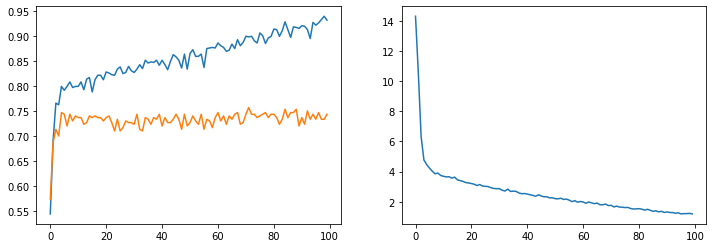

In [292]:
# Actually train
model_all = ConvNetAll(log_softmax=False, softmax=True)
model_all = model_all.to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_all.parameters(), lr=1e-4, weight_decay=0.0001)

dataloader = load_game_data(train_data_combined, train_labels, batch_size=4, shuffle=True)
EPOCHS = 50


dataloader_val = load_game_data(train_data_combined, train_labels, batch_size=1, shuffle=False)
losses_4_all, acc_4_all = train(model_all, criterion, dataloader, dataloader_val, epochs=100, 
                                log_targets=False, model_softmax=True, log=5, val_data=val_data_combined)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_4_all[0])
plt.plot(acc_4_all[1])
plt.subplot(1, 2, 2)
plt.plot(losses_4_all)

In [296]:
dataloader_val = load_game_data(test_data_combined, test_labels, batch_size=1, shuffle=False)
batch_ql, acc, predictions = evaluate(model_all, dataloader_val)
print(batch_ql, acc)

20.642596818084712 0.7466666666666667


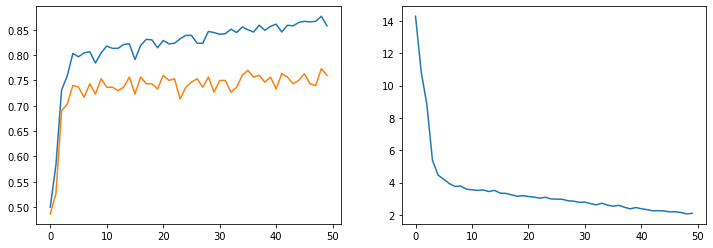

In [287]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_4_all[0])
plt.plot(acc_4_all[1])
plt.subplot(1, 2, 2)
plt.plot(losses_4_all)

Epoch 4  | Training Loss: 5.822510 | Quad Loss: 49.902463 | Acc: 0.772222 | Val Quad Loss: 22.374212 | Val Acc: 0.676667
Epoch 9  | Training Loss: 5.090346 | Quad Loss: 42.025914 | Acc: 0.802222 | Val Quad Loss: 21.028508 | Val Acc: 0.700000
Epoch 14 | Training Loss: 4.742860 | Quad Loss: 41.370831 | Acc: 0.810000 | Val Quad Loss: 21.071638 | Val Acc: 0.680000
Epoch 19 | Training Loss: 4.455477 | Quad Loss: 37.306469 | Acc: 0.815556 | Val Quad Loss: 20.541512 | Val Acc: 0.696667
Epoch 24 | Training Loss: 4.148939 | Quad Loss: 32.899329 | Acc: 0.827778 | Val Quad Loss: 18.600758 | Val Acc: 0.706667
Epoch 29 | Training Loss: 3.762998 | Quad Loss: 30.143518 | Acc: 0.842222 | Val Quad Loss: 17.872159 | Val Acc: 0.716667
Epoch 34 | Training Loss: 3.604200 | Quad Loss: 28.270808 | Acc: 0.855556 | Val Quad Loss: 17.087232 | Val Acc: 0.713333
Epoch 39 | Training Loss: 3.223295 | Quad Loss: 29.632975 | Acc: 0.852222 | Val Quad Loss: 17.873742 | Val Acc: 0.700000
Epoch 44 | Training Loss: 2.9993

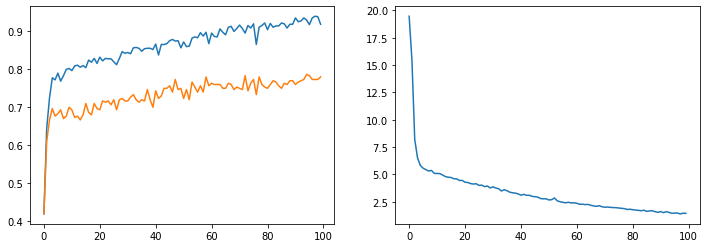

In [312]:
# Actually train
model_all = ConvNetAll(log_softmax=False, softmax=True)
model_all = model_all.to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_all.parameters(), lr=1e-4, weight_decay=0.0001)

dataloader = load_game_data(train_val_data_combined, train_val_labels, batch_size=4, shuffle=True)
EPOCHS = 50

softmax = nn.Softmax(-1)

dataloader_val = load_game_data(train_data_combined, train_val_labels, batch_size=1, shuffle=False)
losses_4_all, acc_4_all = train(model_all, criterion, dataloader, dataloader_val, epochs=100, 
                                log_targets=False, model_softmax=True, log=5, val_data=test_data_combined, val_labels=test_labels)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_4_all[0])
plt.plot(acc_4_all[1])
plt.subplot(1, 2, 2)
plt.plot(losses_4_all)

In [315]:
dataloader_val = load_game_data(test_data_combined, test_labels, batch_size=1, shuffle=False)
batch_ql, acc, predictions = evaluate(model_all, dataloader_val)
print(batch_ql, acc)

17.726559403468855 0.78


Epoch 4  | Training Loss: 5.765525 | Quad Loss: 50.228992 | Acc: 0.774444 | Val Quad Loss: 22.391440 | Val Acc: 0.673333
Epoch 9  | Training Loss: 5.065295 | Quad Loss: 41.252631 | Acc: 0.802222 | Val Quad Loss: 20.927001 | Val Acc: 0.693333
Epoch 14 | Training Loss: 4.715080 | Quad Loss: 41.229034 | Acc: 0.814444 | Val Quad Loss: 21.102099 | Val Acc: 0.700000
Epoch 19 | Training Loss: 4.378521 | Quad Loss: 36.803856 | Acc: 0.815556 | Val Quad Loss: 20.613398 | Val Acc: 0.703333
Epoch 24 | Training Loss: 4.073956 | Quad Loss: 31.868873 | Acc: 0.838889 | Val Quad Loss: 18.604113 | Val Acc: 0.706667
Epoch 29 | Training Loss: 3.641292 | Quad Loss: 29.374754 | Acc: 0.851111 | Val Quad Loss: 17.734584 | Val Acc: 0.740000
Epoch 34 | Training Loss: 3.461947 | Quad Loss: 27.073315 | Acc: 0.858889 | Val Quad Loss: 17.239273 | Val Acc: 0.726667
Epoch 39 | Training Loss: 3.130997 | Quad Loss: 28.555006 | Acc: 0.852222 | Val Quad Loss: 17.674725 | Val Acc: 0.730000
Epoch 44 | Training Loss: 2.9403

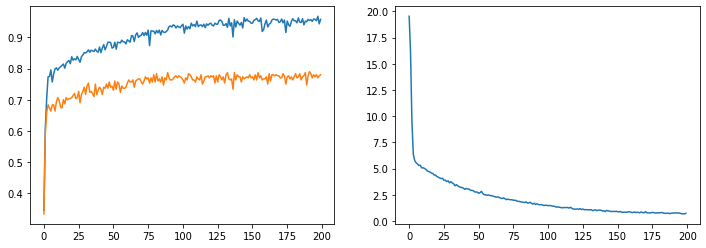

In [340]:
# Actually train
model_all = ConvNetPdBig(log_softmax=False, softmax=True, dropout=0.4, channels=5)
model_all = model_all.to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_all.parameters(), lr=1e-4, weight_decay=0.0001)

dataloader = load_game_data(train_val_data_combined, train_val_labels, batch_size=4, shuffle=True)
EPOCHS = 50

softmax = nn.Softmax(-1)

dataloader_val = load_game_data(train_data_combined, train_val_labels, batch_size=1, shuffle=False)
losses_4_all, acc_4_all = train(model_all, criterion, dataloader, dataloader_val, epochs=200, 
                                log_targets=False, model_softmax=True, log=5, val_data=test_data_combined, val_labels=test_labels)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_4_all[0])
plt.plot(acc_4_all[1])
plt.subplot(1, 2, 2)
plt.plot(losses_4_all)

dataloader_val = load_game_data(test_data_combined, test_labels, batch_size=1, shuffle=False)
batch_ql, acc, predictions = evaluate(model_all, dataloader_val)
print(batch_ql, acc)

### ***Training Setup 5: MSE with Row Values***

In [0]:
np.random.seed(SEED)

# Shuffle data first
game_ix = list(range(len(game_data_row)))
np.random.shuffle(game_ix)

game_data_row_ = game_data_row[game_ix]
game_labels_ = game_labels[game_ix]

# Prepare splits
train_split = int(len(game_data_row_) * TRAIN_SPLIT)
test_split = int(len(game_data_row_) * (TRAIN_SPLIT + VAL_SPLIT))

train_data_row = game_data_row_[:train_split]
val_data_row = game_data_row_[train_split:test_split]
test_data_row = game_data_row_[test_split:]

train_labels = game_labels_[:train_split]
val_labels = game_labels_[train_split:test_split]
test_labels = game_labels_[test_split:]

train_val_data_row = game_data_row_[:test_split]
train_val_labels = game_labels_[:test_split]

Epoch 4  | Training Loss: 5.701913 | Quad Loss: 64.644576 | Acc: 0.779167 | Val Quad Loss: 21.244453 | Val Acc: 0.683333
Epoch 9  | Training Loss: 5.129766 | Quad Loss: 56.414415 | Acc: 0.787500 | Val Quad Loss: 20.209313 | Val Acc: 0.716667
Epoch 14 | Training Loss: 4.812775 | Quad Loss: 61.472096 | Acc: 0.789167 | Val Quad Loss: 21.708628 | Val Acc: 0.703333
Epoch 19 | Training Loss: 4.602893 | Quad Loss: 55.986838 | Acc: 0.803333 | Val Quad Loss: 21.368943 | Val Acc: 0.700000
Epoch 24 | Training Loss: 4.361612 | Quad Loss: 47.913702 | Acc: 0.813333 | Val Quad Loss: 19.517615 | Val Acc: 0.723333
Epoch 29 | Training Loss: 4.058006 | Quad Loss: 46.080485 | Acc: 0.829167 | Val Quad Loss: 19.057167 | Val Acc: 0.723333
Epoch 34 | Training Loss: 3.933606 | Quad Loss: 46.655444 | Acc: 0.830000 | Val Quad Loss: 18.996802 | Val Acc: 0.726667
Epoch 39 | Training Loss: 3.660909 | Quad Loss: 45.500060 | Acc: 0.817500 | Val Quad Loss: 19.592830 | Val Acc: 0.730000
Epoch 44 | Training Loss: 3.3733

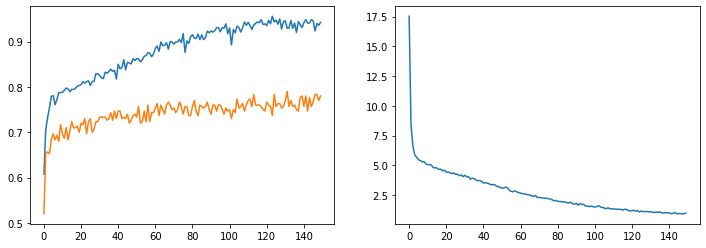

17.630451930810523 0.78


In [334]:
# Actually train
model_row = ConvNetPdBig(log_softmax=False, softmax=True)
model_row = model_row.to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_row.parameters(), lr=1e-4, weight_decay=0.0001)

dataloader = load_game_data(train_val_data_row, train_val_labels, batch_size=4, shuffle=True)
EPOCHS = 50

softmax = nn.Softmax(-1)

dataloader_val = load_game_data(train_val_data_row, train_val_labels, batch_size=1, shuffle=False)
losses_4, acc_4 = train(model_row, criterion, dataloader, dataloader_val, epochs=150, 
                        log_targets=False, model_softmax=True, log=5, val_data=test_data_row, val_labels=test_labels)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_4[0])
plt.plot(acc_4[1])
plt.subplot(1, 2, 2)
plt.plot(losses_4)
plt.show()

dataloader_val = load_game_data(test_data_row, test_labels, batch_size=1, shuffle=False)
batch_ql, acc, predictions = evaluate(model_row, dataloader_val)
print(batch_ql, acc)

Epoch 4  | Training Loss: 6.382774 | Quad Loss: 69.959102 | Acc: 0.754167 | Val Quad Loss: 22.564208 | Val Acc: 0.670000
Epoch 9  | Training Loss: 5.204999 | Quad Loss: 58.410012 | Acc: 0.784167 | Val Quad Loss: 21.083154 | Val Acc: 0.696667
Epoch 14 | Training Loss: 4.875060 | Quad Loss: 60.015268 | Acc: 0.793333 | Val Quad Loss: 21.670844 | Val Acc: 0.680000
Epoch 19 | Training Loss: 4.680266 | Quad Loss: 53.991719 | Acc: 0.800000 | Val Quad Loss: 21.025554 | Val Acc: 0.706667
Epoch 24 | Training Loss: 4.497416 | Quad Loss: 50.849048 | Acc: 0.805833 | Val Quad Loss: 20.286586 | Val Acc: 0.720000
Epoch 29 | Training Loss: 4.167341 | Quad Loss: 47.490196 | Acc: 0.814167 | Val Quad Loss: 19.299420 | Val Acc: 0.746667
Epoch 34 | Training Loss: 4.083513 | Quad Loss: 48.799516 | Acc: 0.801667 | Val Quad Loss: 19.651409 | Val Acc: 0.733333
Epoch 39 | Training Loss: 3.709187 | Quad Loss: 44.389553 | Acc: 0.817500 | Val Quad Loss: 19.153834 | Val Acc: 0.730000
Epoch 44 | Training Loss: 3.4178

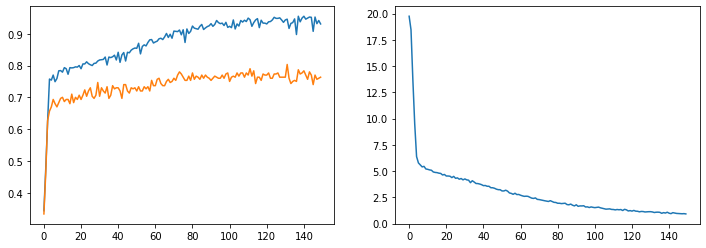

17.290966255852254 0.7633333333333333


In [337]:
# Actually train
model_row = ConvNetPdBig(log_softmax=False, softmax=True, dropout=0.5)
model_row = model_row.to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_row.parameters(), lr=1e-4, weight_decay=0.0001)

dataloader = load_game_data(train_val_data_row, train_val_labels, batch_size=4, shuffle=True)
EPOCHS = 50

softmax = nn.Softmax(-1)

dataloader_val = load_game_data(train_val_data_row, train_val_labels, batch_size=1, shuffle=False)
losses_4, acc_4 = train(model_row, criterion, dataloader, dataloader_val, epochs=150, 
                        log_targets=False, model_softmax=True, log=5, val_data=test_data_row, val_labels=test_labels)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_4[0])
plt.plot(acc_4[1])
plt.subplot(1, 2, 2)
plt.plot(losses_4)
plt.show()

dataloader_val = load_game_data(test_data_row, test_labels, batch_size=1, shuffle=False)
batch_ql, acc, predictions = evaluate(model_row, dataloader_val)
print(batch_ql, acc)

Epoch 4  | Training Loss: 5.901632 | Quad Loss: 67.262234 | Acc: 0.770000 | Val Quad Loss: 21.699906 | Val Acc: 0.660000
Epoch 9  | Training Loss: 5.157899 | Quad Loss: 57.350297 | Acc: 0.789167 | Val Quad Loss: 20.524300 | Val Acc: 0.706667
Epoch 14 | Training Loss: 4.848056 | Quad Loss: 61.768353 | Acc: 0.794167 | Val Quad Loss: 21.736960 | Val Acc: 0.683333
Epoch 19 | Training Loss: 4.635983 | Quad Loss: 55.976854 | Acc: 0.794167 | Val Quad Loss: 21.284713 | Val Acc: 0.700000
Epoch 24 | Training Loss: 4.436032 | Quad Loss: 49.396861 | Acc: 0.809167 | Val Quad Loss: 19.641174 | Val Acc: 0.716667
Epoch 29 | Training Loss: 4.157753 | Quad Loss: 46.546385 | Acc: 0.819167 | Val Quad Loss: 18.935017 | Val Acc: 0.730000
Epoch 34 | Training Loss: 4.032911 | Quad Loss: 47.832927 | Acc: 0.826667 | Val Quad Loss: 18.946390 | Val Acc: 0.726667
Epoch 39 | Training Loss: 3.731548 | Quad Loss: 45.590330 | Acc: 0.815000 | Val Quad Loss: 19.281913 | Val Acc: 0.736667
Epoch 44 | Training Loss: 3.4905

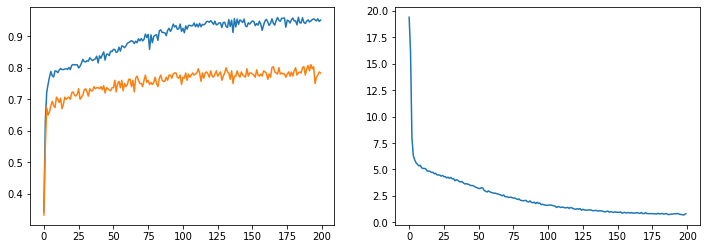

17.09225653229805 0.7833333333333333


In [341]:
# Actually train
model_row = ConvNetPdBig(log_softmax=False, softmax=True, dropout=0.5)
model_row = model_row.to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_row.parameters(), lr=1e-4, weight_decay=0.0001)

dataloader = load_game_data(train_val_data_row, train_val_labels, batch_size=4, shuffle=True)
EPOCHS = 50

softmax = nn.Softmax(-1)

dataloader_val = load_game_data(train_val_data_row, train_val_labels, batch_size=1, shuffle=False)
losses_4, acc_4 = train(model_row, criterion, dataloader, dataloader_val, epochs=200, 
                        log_targets=False, model_softmax=True, log=5, val_data=test_data_row, val_labels=test_labels)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_4[0])
plt.plot(acc_4[1])
plt.subplot(1, 2, 2)
plt.plot(losses_4)
plt.show()

dataloader_val = load_game_data(test_data_row, test_labels, batch_size=1, shuffle=False)
batch_ql, acc, predictions = evaluate(model_row, dataloader_val)
print(batch_ql, acc)

Epoch 4  | Training Loss: 5.761026 | Quad Loss: 67.243911 | Acc: 0.765833 | Val Quad Loss: 21.934753 | Val Acc: 0.666667
Epoch 9  | Training Loss: 4.996306 | Quad Loss: 55.489728 | Acc: 0.786667 | Val Quad Loss: 20.105196 | Val Acc: 0.706667
Epoch 14 | Training Loss: 4.658632 | Quad Loss: 58.297659 | Acc: 0.796667 | Val Quad Loss: 21.411771 | Val Acc: 0.690000
Epoch 19 | Training Loss: 4.461559 | Quad Loss: 53.915015 | Acc: 0.808333 | Val Quad Loss: 21.524064 | Val Acc: 0.686667
Epoch 24 | Training Loss: 4.207497 | Quad Loss: 47.083431 | Acc: 0.820833 | Val Quad Loss: 19.191463 | Val Acc: 0.720000
Epoch 29 | Training Loss: 3.897339 | Quad Loss: 44.013948 | Acc: 0.826667 | Val Quad Loss: 18.347648 | Val Acc: 0.720000
Epoch 34 | Training Loss: 3.733439 | Quad Loss: 45.291057 | Acc: 0.829167 | Val Quad Loss: 18.456995 | Val Acc: 0.706667
Epoch 39 | Training Loss: 3.470712 | Quad Loss: 41.961223 | Acc: 0.836667 | Val Quad Loss: 18.216712 | Val Acc: 0.736667
Epoch 44 | Training Loss: 3.2051

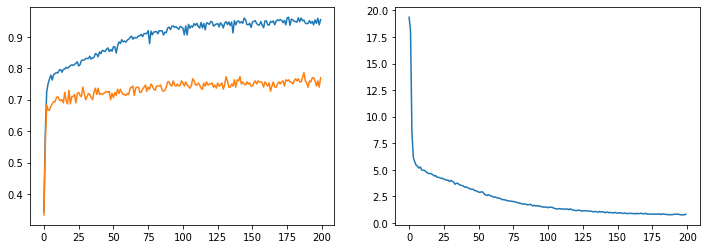

17.352035628609883 0.77


In [37]:
# Actually train
model_row = ConvNetPdBig(log_softmax=False, softmax=True, dropout=0.5)
model_row = model_row.to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_row.parameters(), lr=1e-4, weight_decay=0.0001)

dataloader = load_game_data(train_val_data_row, train_val_labels, batch_size=4, shuffle=True)
EPOCHS = 50

softmax = nn.Softmax(-1)

dataloader_val = load_game_data(train_val_data_row, train_val_labels, batch_size=1, shuffle=False)
losses_4, acc_4 = train(model_row, criterion, dataloader, dataloader_val, epochs=200, 
                        log_targets=False, model_softmax=True, log=5, val_data=test_data_row, val_labels=test_labels)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_4[0])
plt.plot(acc_4[1])
plt.subplot(1, 2, 2)
plt.plot(losses_4)
plt.show()

dataloader_val = load_game_data(test_data_row, test_labels, batch_size=1, shuffle=False)
batch_ql, acc, predictions = evaluate(model_row, dataloader_val)
print(batch_ql, acc)

In [0]:
torch.save(model_row.state_dict(), './model_row_200.pt')

Epoch 4  | Training Loss: 5.697879 | Quad Loss: 66.005964 | Acc: 0.771667 | Val Quad Loss: 21.555327 | Val Acc: 0.670000
Epoch 9  | Training Loss: 5.052921 | Quad Loss: 58.605256 | Acc: 0.779167 | Val Quad Loss: 21.431256 | Val Acc: 0.683333
Epoch 14 | Training Loss: 4.864062 | Quad Loss: 59.997142 | Acc: 0.780833 | Val Quad Loss: 21.775071 | Val Acc: 0.690000
Epoch 19 | Training Loss: 4.587228 | Quad Loss: 53.379947 | Acc: 0.807500 | Val Quad Loss: 21.452565 | Val Acc: 0.700000
Epoch 24 | Training Loss: 4.358051 | Quad Loss: 48.466883 | Acc: 0.815833 | Val Quad Loss: 19.888997 | Val Acc: 0.706667
Epoch 29 | Training Loss: 4.062810 | Quad Loss: 45.206479 | Acc: 0.823333 | Val Quad Loss: 19.180199 | Val Acc: 0.723333
Epoch 34 | Training Loss: 3.925597 | Quad Loss: 43.688180 | Acc: 0.818333 | Val Quad Loss: 18.535941 | Val Acc: 0.733333
Epoch 39 | Training Loss: 3.593582 | Quad Loss: 43.931779 | Acc: 0.816667 | Val Quad Loss: 19.461956 | Val Acc: 0.713333
Epoch 44 | Training Loss: 3.3560

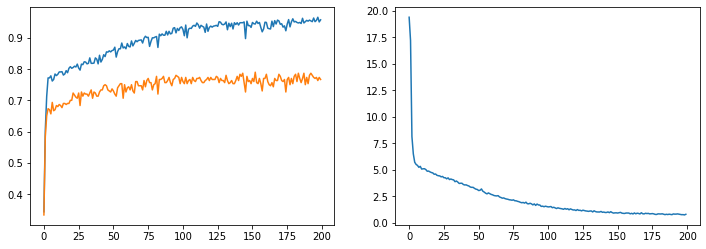

17.362240826478228 0.7666666666666667


In [342]:
# Actually train
model_diffs = ConvNetPdBig(log_softmax=False, softmax=True, dropout=0.5)
model_diffs = model_diffs.to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_diffs.parameters(), lr=1e-4, weight_decay=0.0001)

dataloader = load_game_data(train_val_data_diffs, train_val_labels, batch_size=4, shuffle=True)
EPOCHS = 50

softmax = nn.Softmax(-1)

dataloader_val = load_game_data(train_val_data_diffs, train_val_labels, batch_size=1, shuffle=False)
losses_4, acc_4 = train(model_diffs, criterion, dataloader, dataloader_val, epochs=200, 
                        log_targets=False, model_softmax=True, log=5, val_data=test_data_diffs, val_labels=test_labels)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_4[0])
plt.plot(acc_4[1])
plt.subplot(1, 2, 2)
plt.plot(losses_4)
plt.show()

dataloader_val = load_game_data(test_data_diffs, test_labels, batch_size=1, shuffle=False)
batch_ql, acc, predictions = evaluate(model_diffs, dataloader_val)
print(batch_ql, acc)

## **Diagnose Model**

In [47]:
## Load saved model (with hooks this time)
model_row_h = ConvNetPdBig(softmax=True, dropout=0.5, channels=3)
model_row_h.load_state_dict(torch.load('./model_row_200.pt'))
model_row_h.to(DEVICE)
model_row_h.eval()

ConvNetPdBig(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=3, bias=True)
  (log_softmax): LogSoftmax()
  (softmax): Softmax(dim=1)
  (dropout_conv): Dropout2d(p=0.1, inplace=False)
  (dropout_fcn): Dropout(p=0.5, inplace=False)
)

In [50]:
# Diagnose for single example
dataloader_val = load_game_data(test_data_row, test_labels, batch_size=1, shuffle=False)
data, _ = next(iter(dataloader_val))
pred = model_row_h(data)
target = pred.argmax(dim=1)
print(pred, target)

tensor([[0.0401, 0.7235, 0.2364]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([1], device='cuda:0')


#### **Get heatmap**

In [0]:
# Get gradient of output wrt model params
pred[:, target].backward()

# Pull gradients out of model
gradients = model_row_h.get_activations_gradient()

In [54]:
gradients.shape

torch.Size([1, 128, 3, 3])

In [0]:
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3]) # Pool grads across channels
activations = model_row_h.get_activations(data).detach()  # Get activations of last conv layer

In [61]:
activations.shape

torch.Size([1, 128, 3, 3])

In [66]:
pooled_gradients.shape

torch.Size([128])

In [0]:
# Weight channel activations by gradients
for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

# Calculate heatmap valules
heatmap = torch.mean(activations, dim=1).squeeze()

# ReLU on heatmap
zeros = torch.zeros(heatmap.shape).cuda()
heatmap = torch.max(heatmap, zeros)  # ReLU on heatmap
heatmap /= torch.max(heatmap)  # Normalize

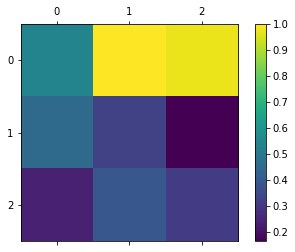

In [81]:
# Visualize
fig = plt.figure()
ax = fig.add_subplot(111)
viz = ax.matshow(heatmap.squeeze().detach().cpu().numpy())
fig.colorbar(viz)

### ***Turn above into a function***

In [0]:
def get_cam_heatmaps(model, dataloader, indices):
    model.eval()

    samples = []
    labels = []
    heatmaps = []

    for batch_ix, (data, label) in enumerate(dataloader):
        samples.append(data)
        labels.append(np.round(label.detach().cpu().numpy().squeeze(), decimals=3))

    selected_samples = [samples[ix] for ix in range(len(samples)) if ix in indices]
    for sample in selected_samples:
        pred = model(sample)
        target = pred.argmax(dim=1)

        # Get gradient of output wrt model params
        pred[:, target].backward()
        # Pull gradients out of model
        gradients = model.get_activations_gradient()

        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3]) # Pool grads across channels
        activations = model.get_activations(data).detach()  # Get activations of last conv layer
        # Weight channel activations by gradients
        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]

        # Calculate heatmap valules
        heatmap = torch.mean(activations, dim=1).squeeze()

        # ReLU on heatmap
        zeros = torch.zeros(heatmap.shape).cuda()
        heatmap = torch.max(heatmap, zeros)  # ReLU on heatmap
        heatmap /= torch.max(heatmap)  # Normalize
        heatmaps.append(heatmap)
    return heatmaps, [labels[ix] for ix in range(len(labels)) if ix in indices]


In [0]:
heatmaps, labels = get_cam_heatmaps(model_row_h, dataloader_val, indices=list(range(9)))

In [156]:
test_data[list(range(9))].shape[2]

3

In [0]:
def visualize_heatmaps(heatmaps, labels, data, show_payoffs=False):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))
    # fig.subplots_adjust(hspace=0., wspace=0.45)

    selected_data = data

    for ix, ax in enumerate(axes.flat):
        viz = ax.matshow(heatmaps[ix].squeeze().detach().cpu().numpy())
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        # ax.text('test', ha='center', va='center')
        if show_payoffs:
            for i in range(selected_data.shape[2]):
                for j in range(selected_data.shape[2]):
                    text = ax.text(j, i, '({}, {})'.format(int(selected_data[ix][0][i, j] * 100),
                                                          int(selected_data[ix][1][i, j] * 100)), 
                                  ha="center", va="center", color="b") 

        ax.title.set_text('{}'.format(labels[ix]))

    fig.colorbar(viz, ax=axes.ravel().tolist())
    plt.show()

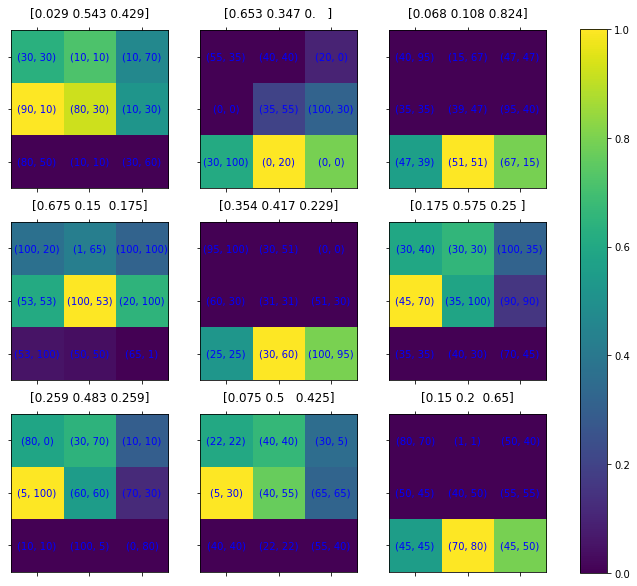

In [176]:
visualize_heatmaps(heatmaps, labels, data=test_data[list(range(9))], show_payoffs=True)

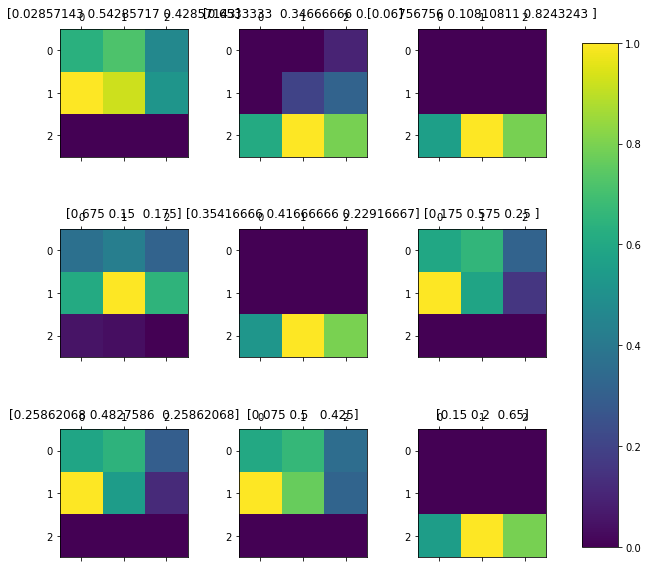

In [116]:
# Visualize
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, len(labels) + 1):
    ax = fig.add_subplot(3, 3, i)
    viz = ax.matshow(heatmaps[i - 1].squeeze().detach().cpu().numpy())
    ax.title.set_text('{}'.format(labels[i - 1]))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(viz, cbar_ax)

In [0]:
indices = [0, 1, 2, 3, 4]
samples = [samples[ix] for ix in range(len(samples)) if ix in indices]

In [95]:
model_row_h(samples)

TypeError: ignored

In [0]:
# Pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = vgg.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [0]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

In [0]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

In [40]:
model_row

ConvNetPdBig(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=3, bias=True)
  (log_softmax): LogSoftmax()
  (softmax): Softmax(dim=1)
  (dropout_conv): Dropout2d(p=0.1, inplace=False)
  (dropout_fcn): Dropout(p=0.5, inplace=False)
)

In [0]:
weight_softmax_params = list(model_row._modules.get('fc1').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

In [399]:
weight_softmax.shape

(512, 1152)

In [0]:
final_layer = model_row._modules.get('conv3')
activated_features = SaveFeatures(final_layer)

In [0]:
dataloader_val = load_game_data(test_data_row, test_labels, batch_size=1, shuffle=False)
batch_ql, acc, predictions = evaluate(model_row, dataloader_val)

In [391]:
predictions = np.array(predictions)
predictions[:5]

array([[0.04563751, 0.7166329 , 0.23772962],
       [0.5967354 , 0.3688699 , 0.03439466],
       [0.06433522, 0.46686777, 0.46879697],
       [0.45359984, 0.17801176, 0.36838844],
       [0.31547526, 0.21376795, 0.4707567 ]], dtype=float32)

In [392]:
np.argmax(predictions, axis=1)

array([1, 0, 2, 0, 2, 1, 1, 1, 2, 2, 1, 0, 0, 2, 2, 2, 1, 1, 2, 2, 1, 2,
       1, 0, 0, 2, 2, 2, 2, 0, 0, 1, 2, 2, 1, 1, 1, 1, 0, 1, 2, 2, 1, 2,
       0, 0, 1, 0, 0, 2, 0, 2, 1, 2, 1, 2, 0, 1, 0, 2, 0, 2, 0, 1, 0, 0,
       2, 0, 1, 0, 2, 1, 0, 0, 0, 0, 1, 2, 1, 2, 0, 1, 0, 2, 1, 1, 0, 0,
       1, 2, 1, 1, 1, 2, 1, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 0, 2, 1, 1, 0,
       1, 1, 0, 2, 1, 0, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 0, 2, 0, 0, 2, 1,
       1, 1, 0, 2, 2, 0, 1, 0, 0, 2, 1, 1, 0, 1, 2, 2, 1, 1, 1, 2, 1, 2,
       1, 1, 1, 2, 2, 2, 0, 1, 0, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 0, 2, 2,
       1, 1, 1, 2, 1, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 2, 1, 0, 1, 0, 2, 0, 1, 2, 2, 1, 2, 0, 2, 2, 1, 1, 2, 1, 0,
       1, 1, 2, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 2, 2, 0, 0, 1,
       2, 0, 1, 0, 0, 0, 2, 2, 2, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       2, 1, 0, 1, 1, 0, 1, 0, 1, 1, 2, 1, 0, 0, 1, 0, 2, 1, 2, 1, 1, 1,
       2, 2, 2, 2, 1, 0, 1, 0, 0, 2, 0, 2, 0, 2])

In [0]:
activated_features.remove() # remove after done
# activated_features.features.shape

In [1]:
weight_softmax.shape

NameError: ignored

In [400]:
overlay = getCAM(activated_features.features, weight_softmax, 1)

ValueError: ignored

In [388]:
activated_features.features

array([[[[ 3.8688742e-02,  1.7184630e-02,  6.6378519e-02],
         [-1.5386041e-02,  6.5069020e-02,  4.2953197e-02],
         [ 1.5674494e-03, -4.2333454e-03,  2.4354625e-03]],

        [[ 3.0153418e-02,  2.3193989e-02,  2.3571312e-02],
         [ 1.1205017e-02,  2.5201745e-02, -1.4763517e-02],
         [ 4.5740135e-02,  6.5841235e-02,  4.5823283e-02]],

        [[ 4.1835260e-02, -5.2370366e-02, -2.6657823e-02],
         [-1.1643205e-02,  1.8086758e-02, -1.3783590e-02],
         [ 4.0572707e-02,  4.8709314e-02,  2.5848698e-02]],

        ...,

        [[ 6.8543460e-03,  1.1192862e-02, -2.0726930e-02],
         [ 3.5880141e-02,  3.1119304e-02,  9.2951907e-03],
         [ 1.1213403e-02,  2.1787619e-02,  1.2599016e-02]],

        [[-4.1150515e-06, -4.1150515e-06, -4.1150515e-06],
         [-4.1150515e-06, -4.1150515e-06, -4.1150515e-06],
         [-4.1150515e-06, -4.1150515e-06, -4.1150515e-06]],

        [[-1.3884043e-02,  4.5776945e-03, -2.7908948e-03],
         [-7.5924210e-05, -1.329

In [374]:
activated_features.features[0]

TypeError: ignored

In [0]:
weight_softmax_params = list(model_row._modules.get('fc4').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

In [383]:
weight_softmax[0].dot()

array([-6.5770811e-10,  7.7598580e-11, -2.8948888e-01,  3.0336350e-03,
        3.0718013e-05, -2.5296274e-01,  8.8949666e-05, -2.4408731e-08,
        1.1941541e-01, -5.4118756e-02,  2.4160750e-01, -9.7254715e-10,
       -3.2542709e-01,  4.4668701e-02,  1.4777220e-04,  1.0206959e-01,
        2.3238575e-01,  1.8926798e-01, -8.0664247e-02,  1.2036084e-01,
       -1.6741614e-01,  1.1056077e-01, -9.4710886e-02, -1.9178215e-01,
       -1.5792608e-01,  3.4375943e-04,  2.1436773e-01, -1.5674756e-01,
       -3.0436820e-01,  2.4172257e-01,  2.0573156e-01, -3.4650333e-07],
      dtype=float32)

In [378]:
weight_softmax[0]

array([-6.5770811e-10,  7.7598580e-11, -2.8948888e-01,  3.0336350e-03,
        3.0718013e-05, -2.5296274e-01,  8.8949666e-05, -2.4408731e-08,
        1.1941541e-01, -5.4118756e-02,  2.4160750e-01, -9.7254715e-10,
       -3.2542709e-01,  4.4668701e-02,  1.4777220e-04,  1.0206959e-01,
        2.3238575e-01,  1.8926798e-01, -8.0664247e-02,  1.2036084e-01,
       -1.6741614e-01,  1.1056077e-01, -9.4710886e-02, -1.9178215e-01,
       -1.5792608e-01,  3.4375943e-04,  2.1436773e-01, -1.5674756e-01,
       -3.0436820e-01,  2.4172257e-01,  2.0573156e-01, -3.4650333e-07],
      dtype=float32)

In [0]:
class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            x = module(x)  # Forward
            if int(module_pos) == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = self.model.classifier(x)
        return conv_output, x


class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Zero grads
        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        # Backward pass with specified target
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        # Get hooked gradients
        guided_gradients = self.extractor.gradients.data.numpy()[0]
        # Get convolution outputs
        target = conv_output.data.numpy()[0]
        # Get weights from gradients
        weights = np.mean(guided_gradients, axis=(1, 2))  # Take averages for each gradient
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        # Multiply each weight with its conv output and then, sum
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       input_image.shape[3]), Image.ANTIALIAS))/255
        # ^ I am extremely unhappy with this line. Originally resizing was done in cv2 which
        # supports resizing numpy matrices with antialiasing, however,
        # when I moved the repository to PIL, this option was out of the window.
        # So, in order to use resizing with ANTIALIAS feature of PIL,
        # I briefly convert matrix to PIL image and then back.
        # If there is a more beautiful way, do not hesitate to send a PR.

        # You can also use the code below instead of the code line above, suggested by @ ptschandl
        # from scipy.ndimage.interpolation import zoom
        # cam = zoom(cam, np.array(input_image[0].shape[1:])/np.array(cam.shape))
        return cam

In [0]:
grad_cam = GradCam(model_row, target_layer=1)

In [405]:
test_data_row[0]

array([[[ 0.3,  0.1,  0.1],
        [ 0.9,  0.8,  0.1],
        [ 0.8,  0.1,  0.3]],

       [[ 0. ,  0. , -0.6],
        [ 0.8,  0.5, -0.2],
        [ 0.3,  0. , -0.3]],

       [[-0.6, -0.8, -0.8],
        [ 0. , -0.1, -0.8],
        [-0.1, -0.8, -0.6]]])

In [406]:
cam = grad_cam.generate_cam(test_data_row[0], 1)

AttributeError: ignored